# HSE 2025: Mathematical Methods for Data Analysis

## Seminar 9: Gradient boosting

# Gradient Boosting
Gradient boosting (GB) is a machine learning algorithm developed in the late '90s that is still very popular. It produces state-of-the-art results for many commercial (and academic) applications. Gradient boosting builds an ensemble of trees one-by-one, then the predictions of the individual trees are summed.


 In boosting, several weak learners (high bias and low variance models) are combined additively to produce an ensemble with reduced bias while maintaining the low variance.

## Gradient boosting vs Random forest

First of all, we need to solve the task:

A sample of $\ell$ objects with $d$ features is given. Give the time asymptotics of learning and making predictions for a composition $a_N(x) = \sum_{n=0}^N b_n (x)$ over decision trees $b_n$ of depth at most $D$.

#### Solution

For training, we need to fit $N$ trees, so the asymptotics will be $N * T_{tree}$, where $T_{tree}$ is the complexity of constructing a single decision tree. When constructing a single tree, consider the complexity of finding the optimal partition at a single vertex. Consider how much time is spent on building a single level in the decision tree. Denote by $\ell^i_j$ - the number of objects from the training sample that reach the vertex $j$ at the $i$ - th level.


We need to check $d$ of features by the $\ell^i_j - 1$ thresholds. Calculating the partitioning quality metric takes $O (\ell^i_j)$ time. However, you can implement the $\textit{optimal}$ algorithm with pre-calculated statistics, which for each feature can calculate the metric for all $\ell^i_j - 1$ thresholds in $O(\ell^i_j)$ time. Hence, a single vertex requires $d * O (\ell^i_j) = O (d\ell^i_j)$ time.

It is clear that $\ell^1_1 = \ell$, since this is the root vertex. Further, for any $i, j$, it is true that $\ell^i_j = \ell^{i + 1}_{2j-1} + \ell^{i + 1}_{2j}$ by the principle of source-sink conservation (the number of objects originating from one vertex to its children is equal to the number of objects entering this vertex). It follows that in total there will be only $\ell$ objects on one level, $\forall i ~:~ \sum\limits^{2^i}_{j=1} \ell^i_j = \ell$. So, to build one level in the decision tree, we need only $ \sum \limits^{2^i}_{j=1} O (d\ell^i_j) = O (d\ell)$, and the levels are only $D$. Therefore, to build a single tree, you need $T_{tree} = O(Dd\ell)$ of time. We have $N$ trees, hence the total time to build all the trees, and hence for all the training: $O(NDd\ell)$

At the stage of constructing a forecast for the object $x$, it is "passed" through the tree from the root to the leaves, thereby passing a path of no more than $D$ internal vertices, each of which checks the predicate in constant time. Hence, we have the asymptotics for constructing the composition prediction - $O (ND)$.

### Changing the number of algorithms

Let's compare how boosting and bagging behave with the growth of the number of basic algorithms.

In the case of bagging, all the underlying algorithms are tuned to different samples from the same distribution at $\mathbb{X} \times \mathbb{Y}$. At the same time, some of them may be overfitted, but averaging allows you to weaken this effect (due to the fact that for uncorrelated algorithms, the spread of the composition is $N$ times less than the spread of individual algorithms, i.e. many trees are less likely to tune in to some atypical object compared to a single tree). If $N$ is large enough, then subsequent additions of new algorithms will no longer improve the quality of the model.

In the case of boosting, each algorithm is adjusted to the errors of all the previous ones, this allows you to adjust to the original distribution more and more accurately at each step. However, with a sufficiently large $N$, this is a source of overfitting, since subsequent additions of new algorithms will continue to tune to the training sample, reducing the error on it, while reducing the generalization ability of the final composition.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

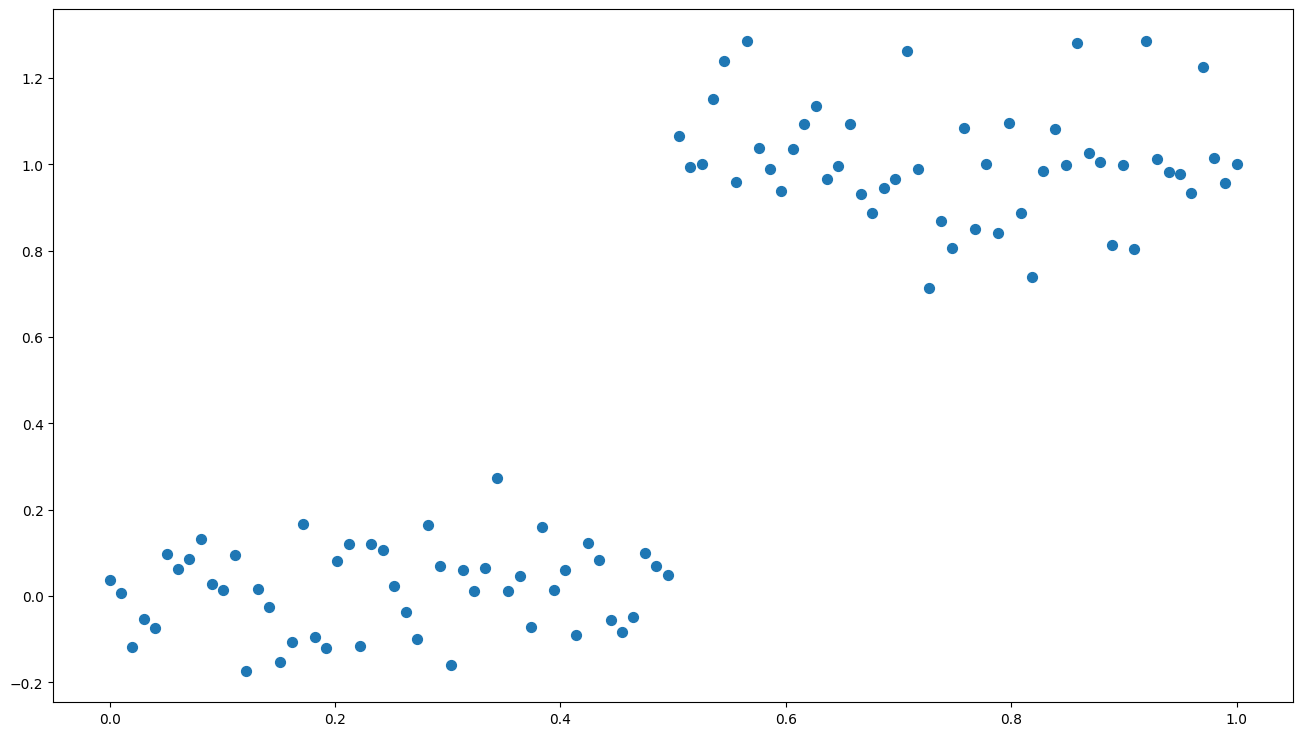

In [ ]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50);

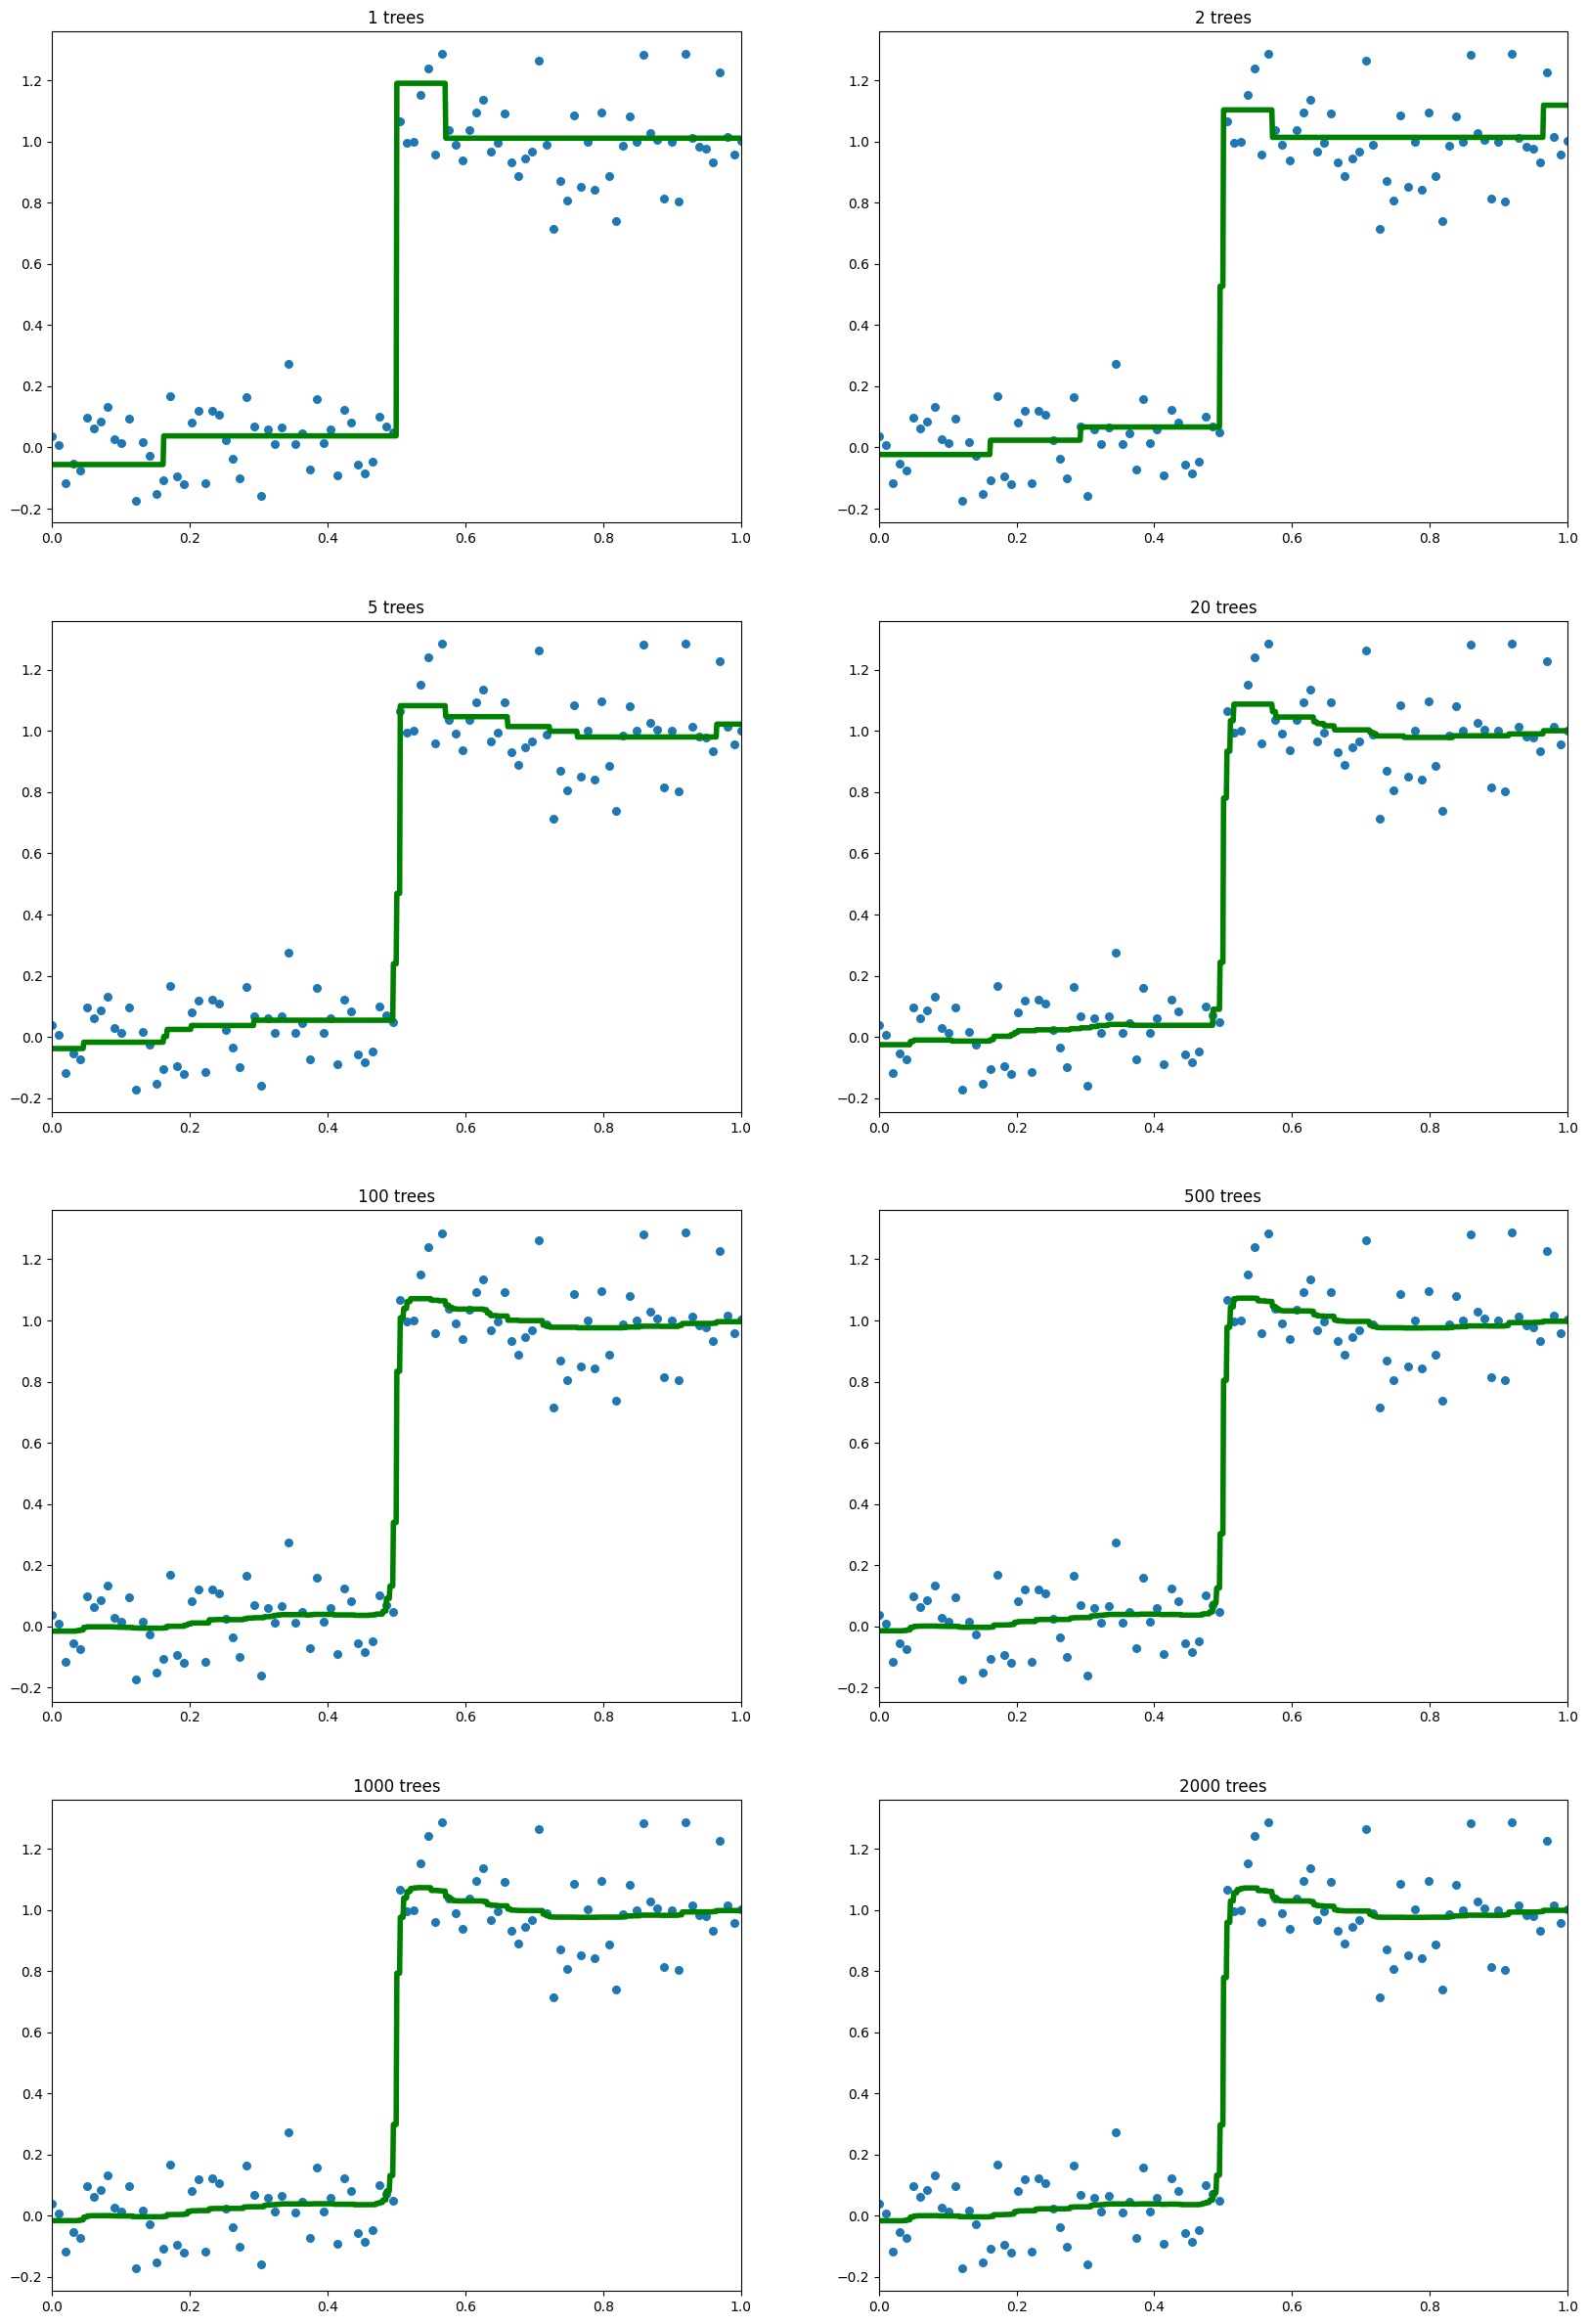

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

You can see that from some point on, the resulting function stops changing with the growth of the number of trees.

Now let's do the same for gradient boosting.

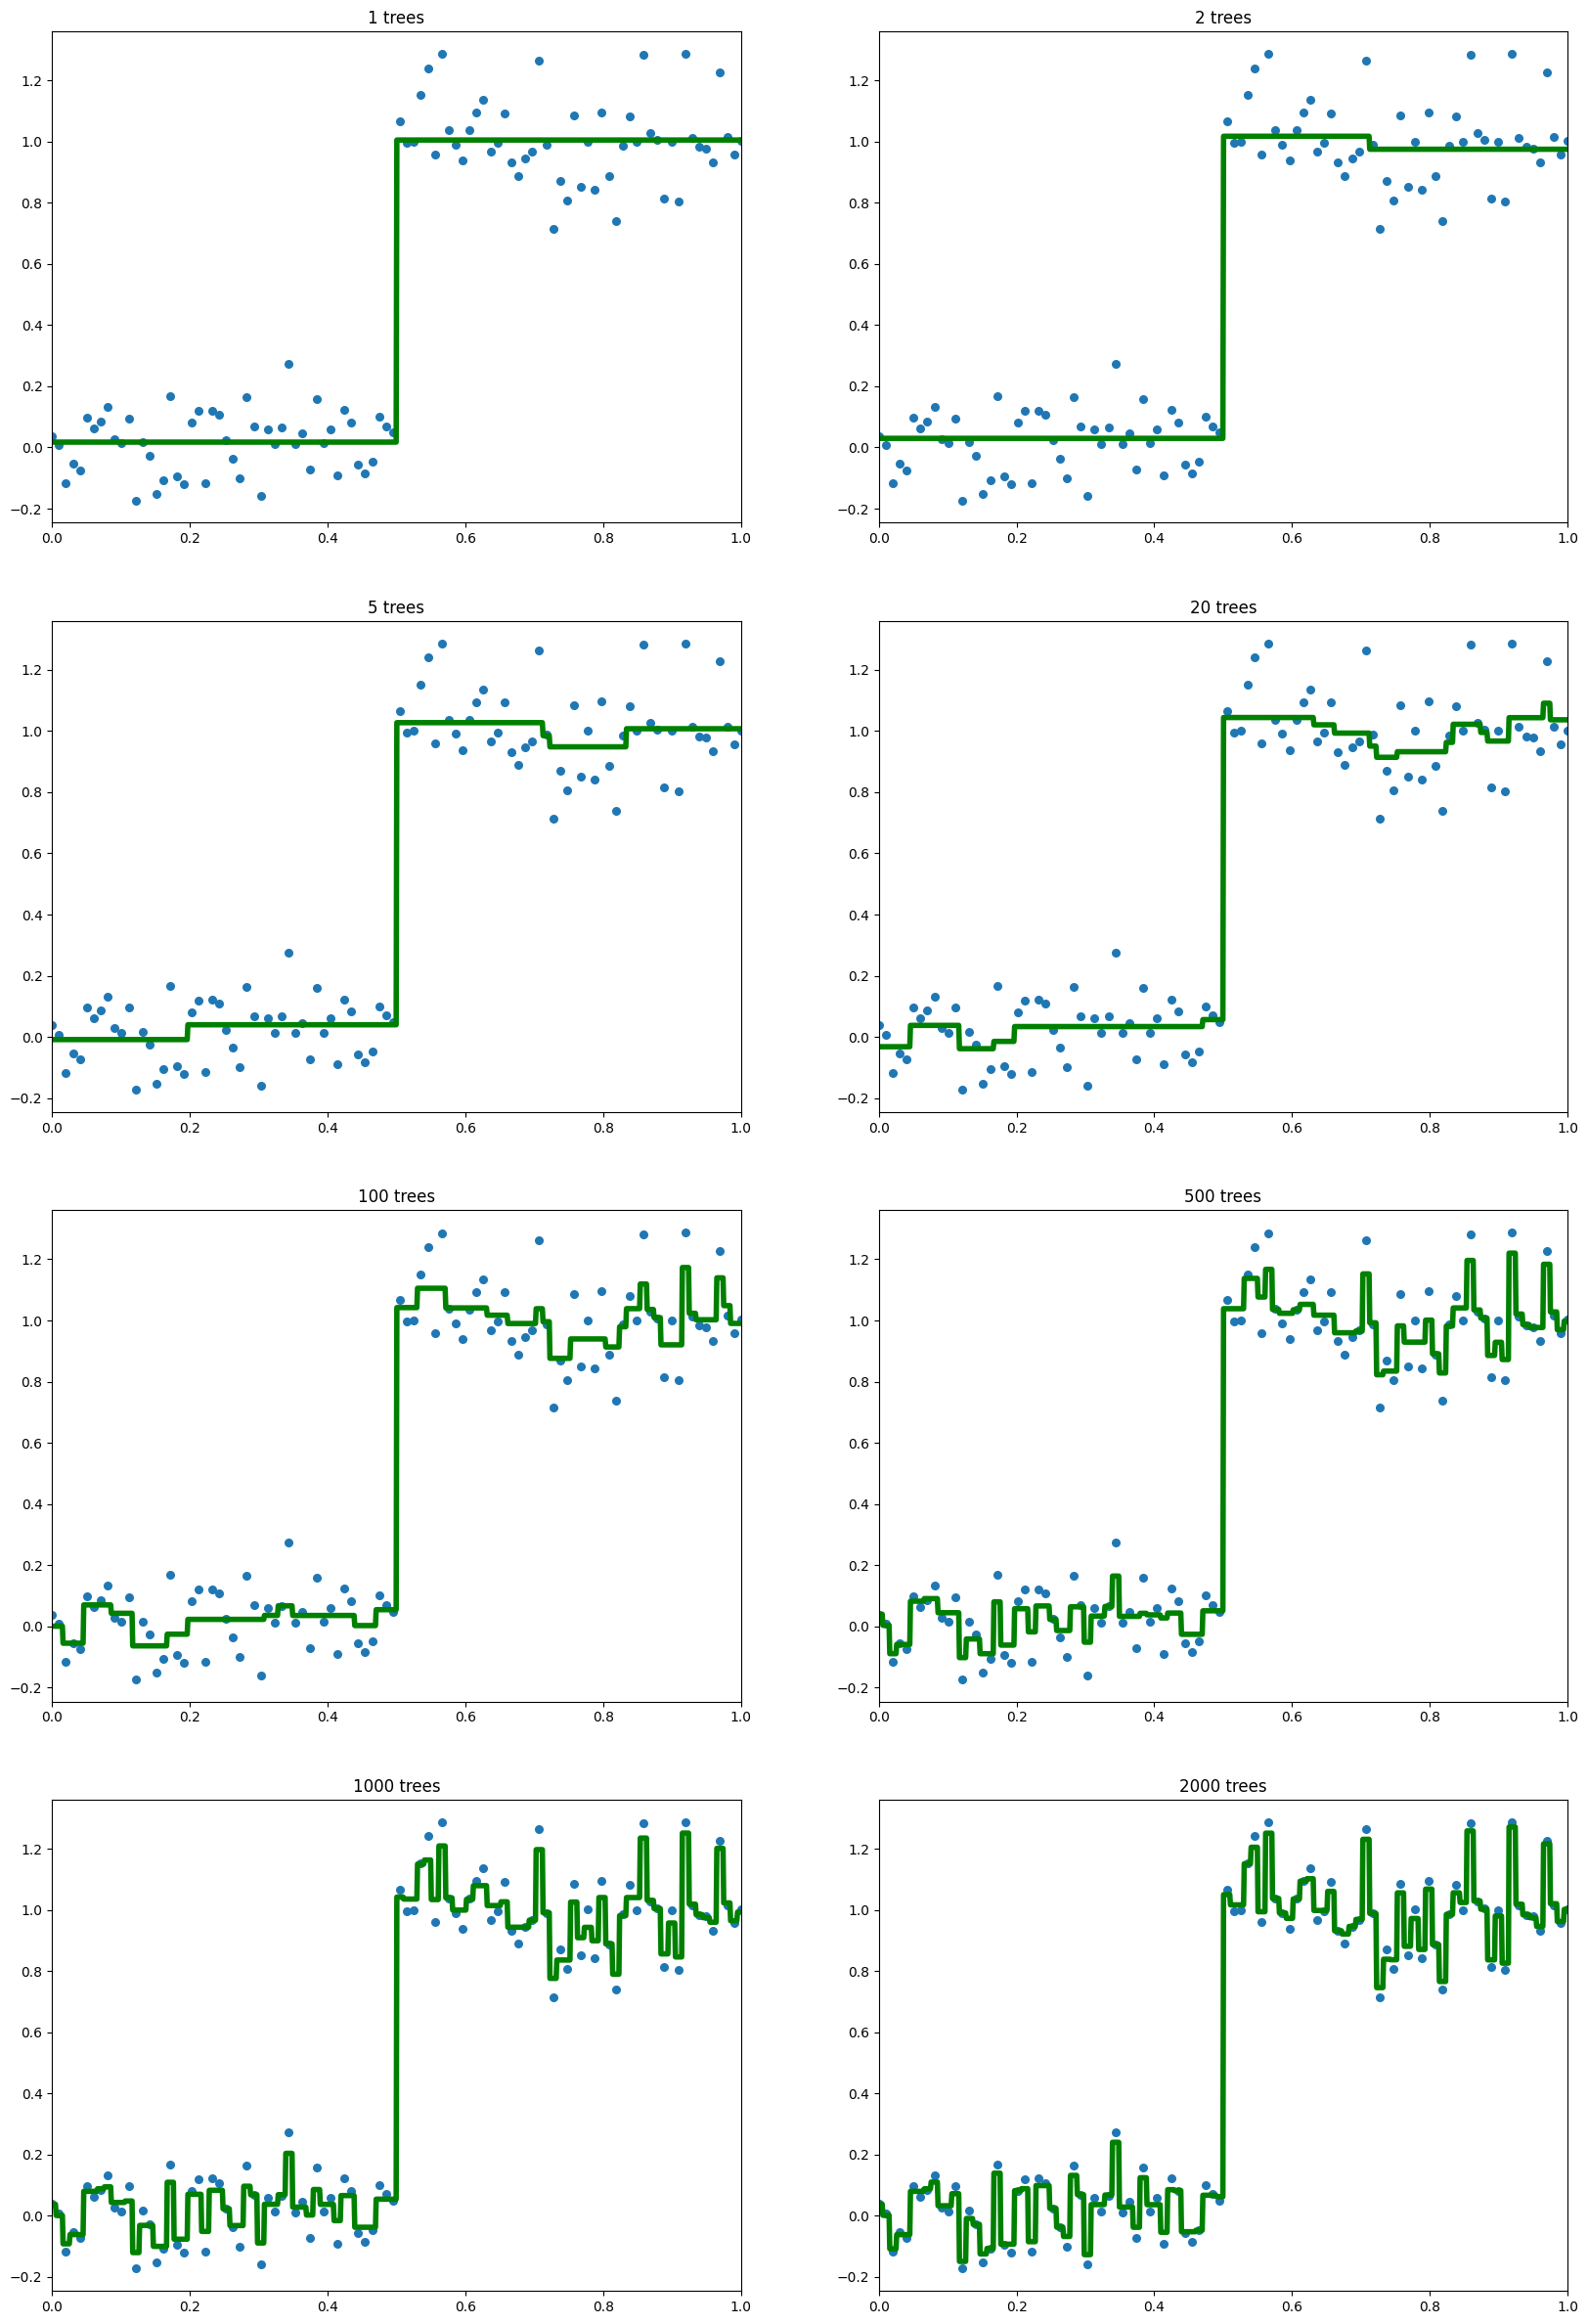

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Gradient boosting quickly finds a true dependency, after which it begins adjusting to specific objects in the training sample, thus, it greatly overfits.

To deal with this problem, you can choose a very simple basic algorithm or
artificially reduce the weight of new algorithms using the step $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

This correction slows down learning compared to bagging, but it allows you to get reduce overfitting. However, it is important to understand that overfitting will still take place when training an arbitrarily large number of basic algorithms for a fixed $\eta$.

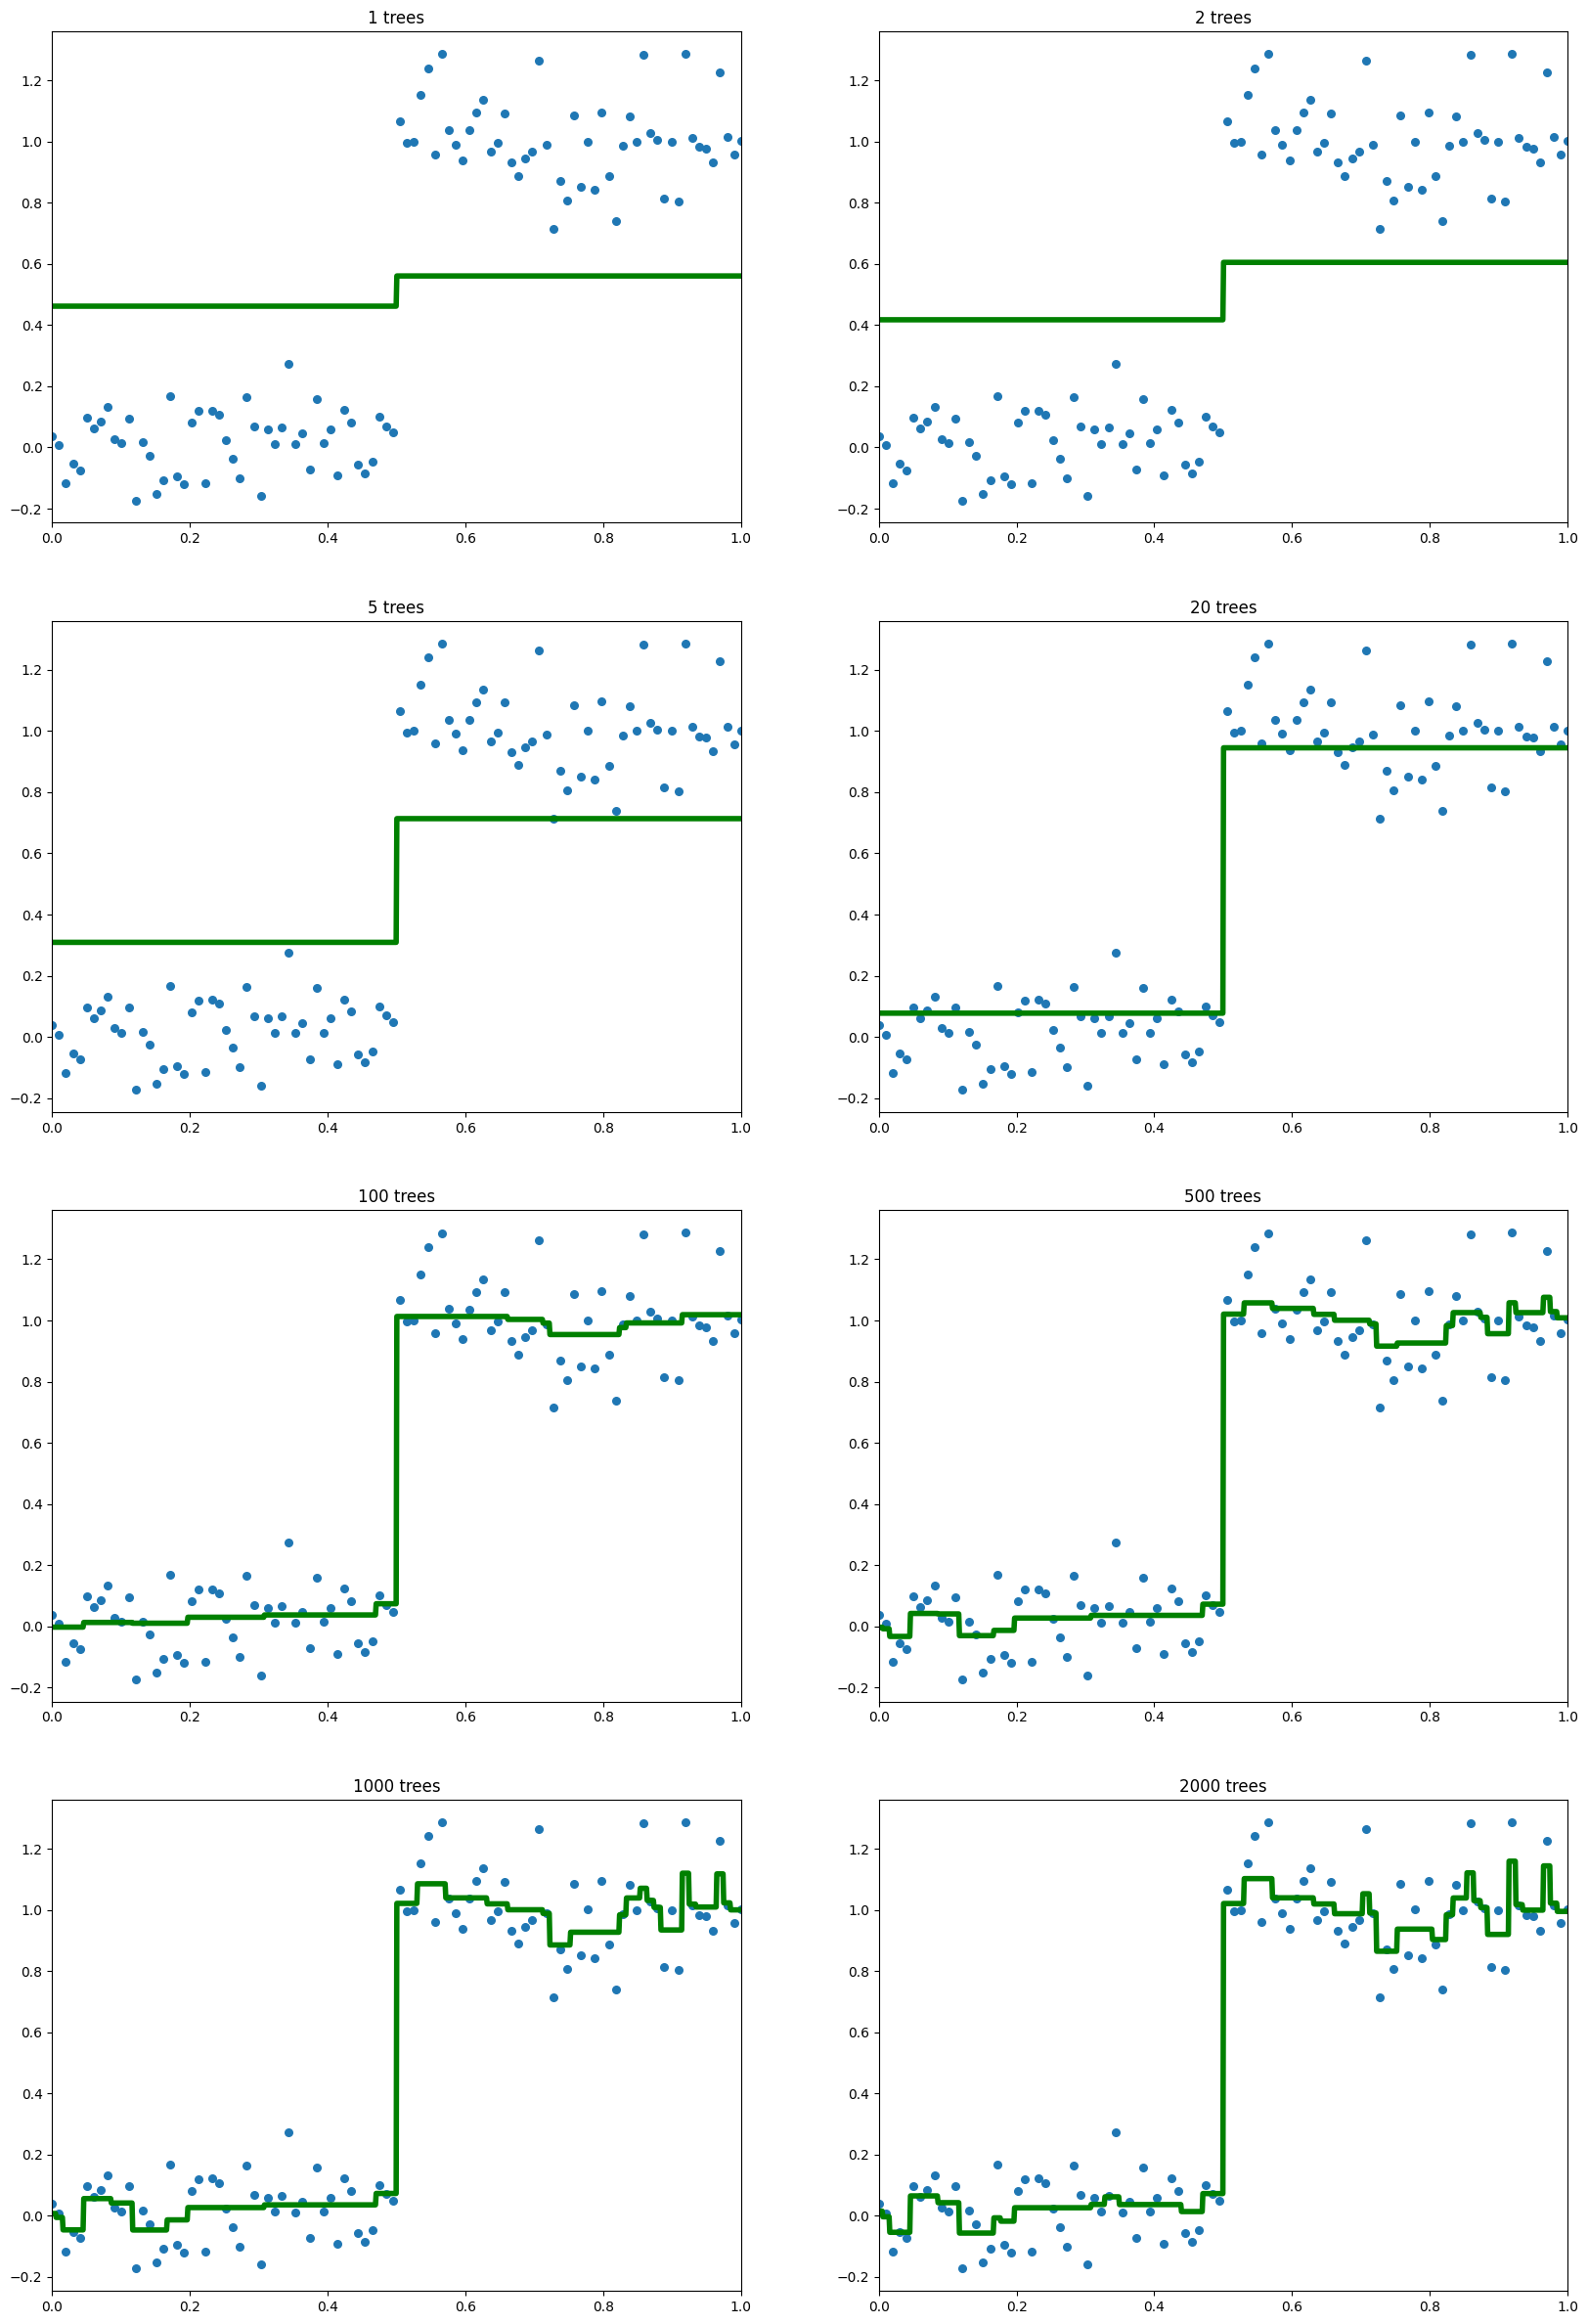

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Now let's test the effect described above on real data.

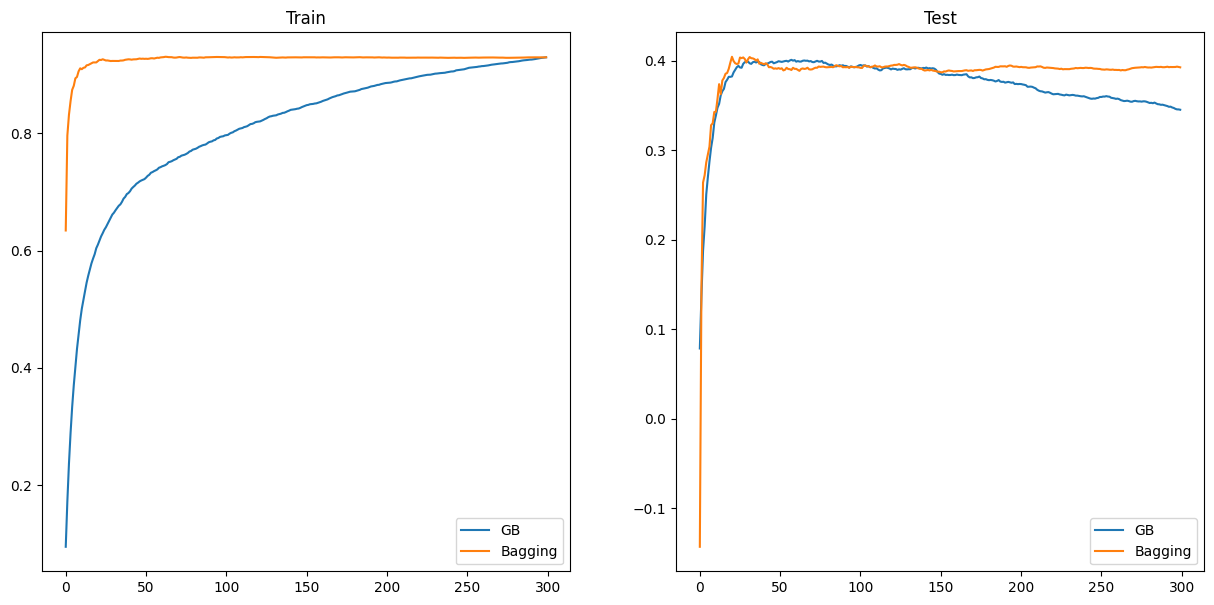

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(gbclf.score(X_train, Y_train)) # R2 returning
    err_test_bag.append(gbclf.score(X_test, Y_test)) # R2 returning

gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(gbclf.score(X_train, Y_train)) # R2 returning
    err_test_gb.append(gbclf.score(X_test, Y_test)) # R2 returning

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Quality of algorithms

Let's compare the behavior of two methods. For this purpose let's construct a composition of algorithms over decision trees on [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) task:

The data is in the comma separated values (CSV) format. Each row in this data set represents a molecule. The first column contains experimental data describing a real biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are caclulated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The descriptor matrix has been normalized.

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# https://drive.google.com/file/d/1yAOlsXMjSjI-XPwMGFq3PU6BKlib1xha
data = pd.read_csv('https://github.com/darkydash/ml_hse_2024/raw/refs/heads/main/week09/train.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [ ]:
%%time
gbm = GradientBoostingClassifier(
    n_estimators=250, learning_rate=0.2, verbose=True
).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           20.69s
         2           1.1722           18.24s
         3           1.1009           17.54s
         4           1.0528           17.03s
         5           1.0129           17.01s
         6           0.9739           17.13s
         7           0.9473           17.22s
         8           0.9194           16.89s
         9           0.9008           16.74s
        10           0.8814           16.49s
        20           0.7201           15.76s
        30           0.5950           14.91s
        40           0.5214           14.37s
        50           0.4482           13.75s
        60           0.3862           12.99s
        70           0.3427           12.25s
        80           0.3014           11.56s
        90           0.2723           11.21s
       100           0.2390           10.99s
       200           0.0787            3.58s
CPU times: user 17.6 s, sys: 32.6 ms, total: 17.6 s
Wa

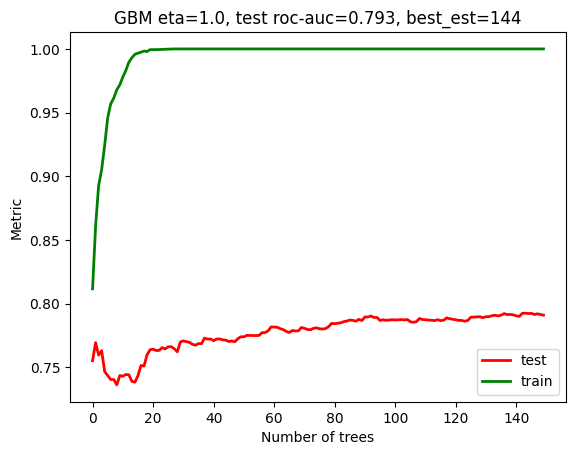

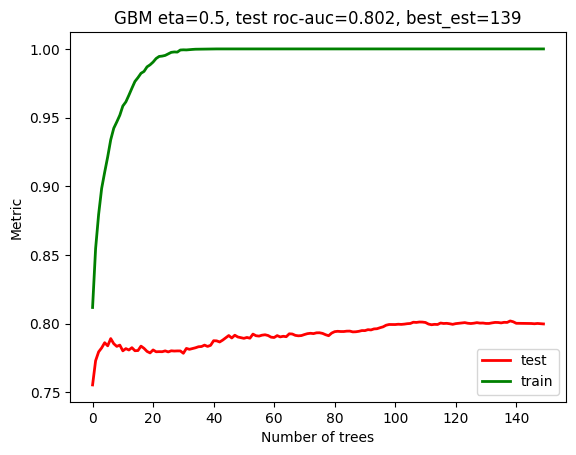

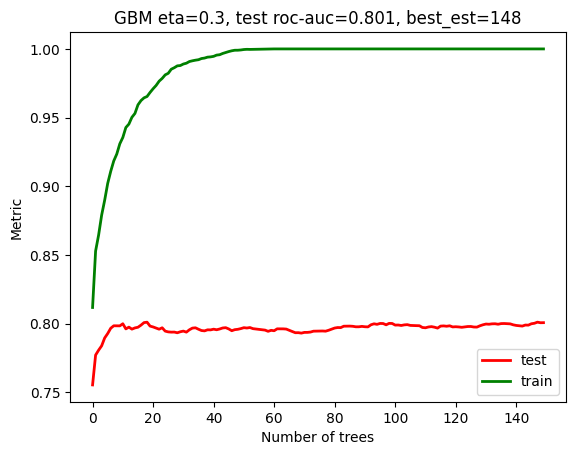

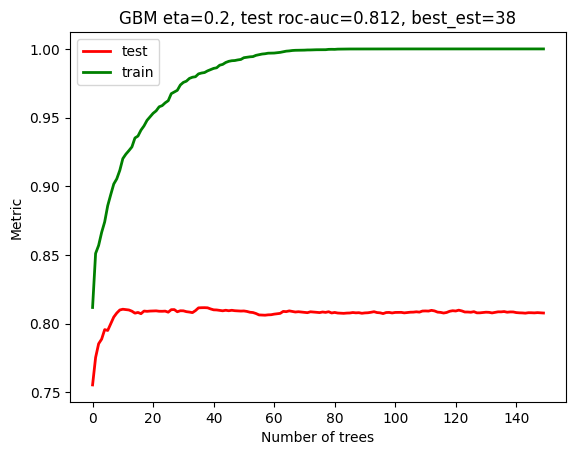

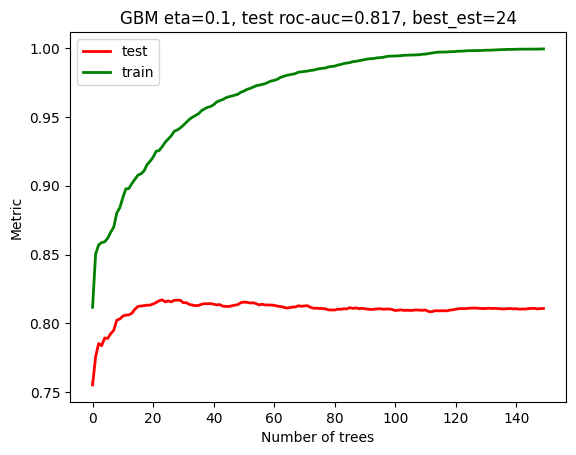

In [ ]:
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(
        n_estimators=150, learning_rate=learning_rate, random_state=241
    ).fit(X_train, y_train)

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        test_deviance[i] = roc_auc_score(y_test, y_pred)

    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])

    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (
        learning_rate, test_deviance.max(), test_deviance.argmax()+1)
             )
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

In total, the best composition is built at $\eta = 0.1$. It includes 24 basic algorithms, and reaches a value of 0.817 on the control sample. At the same time, a random forest with the same number of basic algorithms is inferior to gradient boosting:

In [ ]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Note also that with all this, random forest, unlike gradient boosting, uses deep trees that require computing power to train them.

To achieve the same quality, a random forest requires a much larger number of basic algorithms:

In [ ]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(
        n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train
                                                )
    print (
        n_estimators, 'trees: train ROC-AUC =',
        roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]),
        'test ROC-AUC =',
        roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
    )

10 trees: train ROC-AUC = 0.9996868416557535 test ROC-AUC = 0.7700854896346846
20 trees: train ROC-AUC = 0.999985765529807 test ROC-AUC = 0.7919738768217338
30 trees: train ROC-AUC = 0.9999964413824518 test ROC-AUC = 0.8040678660868691
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8163524601927395
50 trees: train ROC-AUC = 0.9999999999999999 test ROC-AUC = 0.8209469338184114
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8197187659211103
70 trees: train ROC-AUC = 0.9999999999999999 test ROC-AUC = 0.820634341879606
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8203955252262142
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8243603301544931
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8267397512898342


Finally, you can see [visualization](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) gradient boosting for decision trees of different depths for functions of different types.

## Modern gradient boosting libraries

Previously, we used a naive version of gradient boosting from scikit-learn, [invented] (https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) in 1999 by Friedman. Since then, many implementations have been proposed that prove to be better in practice. To date, three popular libraries that implement gradient boosting:
* XGBoost. After its release, it quickly gained popularity and remained the standard until the end of 2016. The features of this library were discussed at the lecture.
* LightGBM. A distinctive feature is the speed of composition construction. For example, the following trick is used to speed up learning: when building a tree vertex, instead of iterating over all the values of a feature, the values of the histogram of this feature are iterated over. So instead of $O (\ell)$ requires $O$(#bins). In addition, unlike other libraries that build a tree by levels, LightGBM uses the best-first strategy, i.e., at each step, it builds the vertex that gives the greatest reduction in the functional. Thus, each tree is a chain with attached leaves, so the restriction on num_leaves is more meaningful.
* CatBoost. Library from Yandex. Allows automatic processing of categorical features. In addition, the algorithm is less sensitive to the choice of specific hyperparameters. This reduces the time that a person spends on selecting the optimal hyperparameters.

### Basic parameters

(lightgbm/catboost)

* objective-the functionality that the composition will be configured for
* eta / learning_rate – learning rate
* num_iterations / n_estimators – number of boosting iterations

#### Parameters responsible for the complexity of trees
* max_depth – maximum depth
* max_leaves / num_leaves – the maximum number of vertices in the tree
* gamma / min_gain_to_split-threshold for reducing the error function when splitting in the tree
* min_data_in_leaf – minimum number of objects in the leaf
* min_sum_hessian_in_leaf – the minimum sum of the weights of objects in the leaf, the minimum number of objects at which splitting is done
* lambda-regularization coefficient (L2)
* subsample / bagging_fraction – which part of the learning objects to use to build a single tree
* colsample_bytree / feature_fraction – which part of the features to use to build a single tree

The selection of all these parameters is a real art. But you can start setting them up with the most important parameters: learning_rate and n_estimators. Usually, one of them is fixed, and the remaining of these two parameters is selected (for example, n_estimators=1000 is fixed and learning_rate is selected). Next in importance is max_depth. Due to the fact that we are interested in shallow trees, it is usually sorted out from the range [3; 7].

In [ ]:
!pip install catboost --quiet
!pip install lightgbm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


<b>WARNING:</b> you might additionally need to install libomp on mac to avoid errors running lightgbm; easiest via brew: <br>
`brew install libomp` <br>
Check here for reference: <br>
https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded

In [ ]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from tqdm import tqdm

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=241
)

## Catboost

0.919452347083926


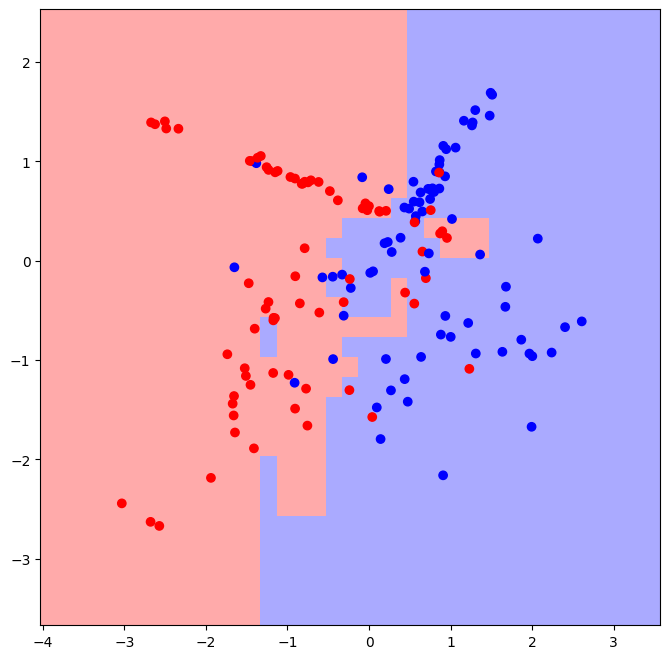

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

Let's look at examples of how these libraries work on a dataset [Diabetes Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset)

It has two categorical features - `gender` and `smoking_history`

In [ ]:
data = pd.read_csv('https://github.com/darkydash/ml_hse_2024/raw/refs/heads/main/week09/diabetes_prediction_dataset.csv')

X_cat = data.drop('diabetes', axis=1)
y = data['diabetes']

X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_cat, y, test_size=0.3, random_state=241
)

X_train_cat.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
26977,Female,45.0,0,0,No Info,23.71,6.2,80
56535,Male,44.0,0,0,former,26.91,4.0,155
7415,Male,71.0,0,0,never,27.32,6.2,80
69398,Female,51.0,0,0,never,24.54,6.6,100
10320,Male,37.0,0,0,not current,27.32,4.8,90


As mentioned before, `CatBoost` can automatically process categorical features

100%|██████████| 11/11 [01:18<00:00,  7.14s/it]


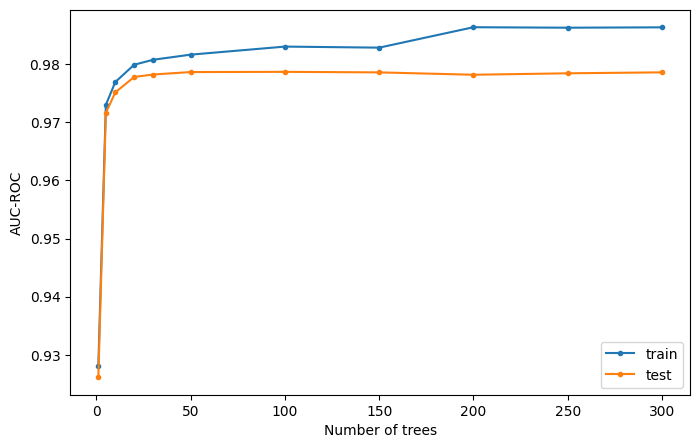

In [ ]:
n_trees = [1, 5, 10, 20, 30, 50, 100, 150, 200, 250, 300]
quals_train = []
quals_test = []
for n in tqdm(n_trees):
    clf = CatBoostClassifier(iterations=n,
                             cat_features=['gender', 'smoking_history'], # explicitly set, which features are categorical
                             logging_level='Silent')
    clf.fit(X_train_cat, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train_cat)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test_cat)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

If you get error running cell below on mac, you might need to install libomp; easiest via brew: <br>
`brew install libomp` <br>
Check here for reference: <br>
https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded

In case `LightGBM` encode categorical features using `OneHotEncoder`

In [ ]:
X_lgb = data.drop('diabetes', axis=1)
X_lgb = pd.get_dummies(X_lgb, columns=['gender', 'smoking_history'])

X_train_lgb, X_test_lgb, y_train, y_test = train_test_split(
    X_lgb, y, test_size=0.3, random_state=241
)

X_train_lgb.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
26977,45.0,0,0,23.71,6.2,80,True,False,False,True,False,False,False,False,False
56535,44.0,0,0,26.91,4.0,155,False,True,False,False,False,False,True,False,False
7415,71.0,0,0,27.32,6.2,80,False,True,False,False,False,False,False,True,False
69398,51.0,0,0,24.54,6.6,100,True,False,False,False,False,False,False,True,False
10320,37.0,0,0,27.32,4.8,90,False,True,False,False,False,False,False,False,True


In [ ]:
from lightgbm import LGBMClassifier

lgb_params = {"verbose": -1} # disable verbose
clf_lgb = LGBMClassifier(n_estimators=300, n_jobs=1, **lgb_params) #n_jobs set to 1 to prevent
                                                #hanging when using certain compilers
clf_lgb.fit(X_train_lgb, y_train)

print(roc_auc_score(y_test, clf_lgb.predict_proba(X_test_lgb)[:, 1]))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=64.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

Again select the optimal number of trees

In [ ]:
n_trees = [1, 5, 10, 20, 30, 50, 100, 150, 200, 250, 300]
quals_train = []
quals_test = []
for n in tqdm(n_trees):
    clf = LGBMClassifier(n_estimators=n, n_jobs=1, **lgb_params)
    clf.fit(X_train_lgb, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train_lgb)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test_lgb)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Now we will try to take a fixed number of trees, but we will change the depth of them:

In [ ]:
depth = list(range(1, 14, 2))
n_trees = 50
quals_train = []
quals_test = []
for d in tqdm(depth):
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d, n_jobs=1, **lgb_params)
    lgb.fit(X_train_lgb, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train_lgb)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test_lgb)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

And compare it with Catboost:

100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


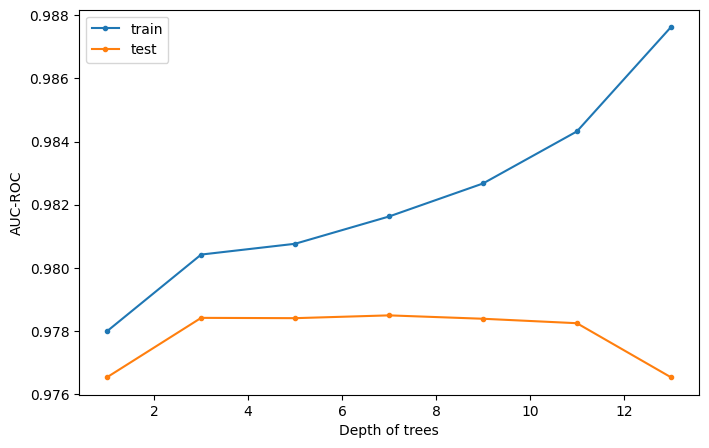

In [ ]:
depth = list(range(1, 14, 2))
n_trees = 50
quals_train = []
quals_test = []
for d in tqdm(depth):
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d,
                             cat_features=['gender', 'smoking_history'],
                             logging_level="Silent")

    clf.fit(X_train_cat, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train_cat)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test_cat)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Now that we have great models, we need to save them!

In [ ]:
clf_lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

And we'll upload them back when we need to apply them:

In [ ]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Blending

As it was described in the lecture, blending is a "meta-algorithm", the prediction of which is built as a weighted sum of the basic algorithms. Consider a simple example of blending boosting and linear regression.

In [ ]:
!wget https://github.com/darkydash/ml_hse_2024/raw/refs/heads/main/week09/boston.pkl

--2025-10-20 11:32:40--  https://github.com/darkydash/ml_hse_2024/raw/refs/heads/main/week09/boston.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/darkydash/ml_hse_2024/refs/heads/main/week09/boston.pkl [following]
--2025-10-20 11:32:41--  https://raw.githubusercontent.com/darkydash/ml_hse_2024/refs/heads/main/week09/boston.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59783 (58K) [application/octet-stream]
Saving to: ‘boston.pkl’

boston.pkl          100%[===================>]  58.38K  --.-KB/s    in 0.01s   

2025-10-20 11:32:41 (4.54 MB/s) - ‘boston.pkl’ saved [59783/59783]



In [ ]:
#from sklearn.datasets import load_boston
import pickle


data = pickle.load(open('boston.pkl', 'rb'))
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [ ]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(
    iterations=100, max_depth=4, learning_rate=0.01,
    loss_function='RMSE', logging_level='Silent'
)
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


For simplicity, we assume that the new algorithm $a(x)$ is represented as
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
where $\sum_{n} w_n =1$

In [ ]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [ ]:
rmse_blending_train, w_0, w_1 = min(
    select_weights(y_train, y_train_pred_cbm, y_train_pred_lr),
    key=lambda x: x[0]
)

In [ ]:
# train RMSE

rmse_blending_train

np.float64(4.273424051954005)

In [ ]:
# test RMSE

rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

np.float64(5.237314717927903)

As a result, we get a better quality on the test sample than each algorithm separately.